In [1]:
pip install pybbn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd  
import networkx as nx 
import matplotlib.pyplot as plt 

from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

***Q1***

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('weatherAUS.csv')

In [5]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

In [6]:
df = df.fillna(df.mean())

<ipython-input-6-04e87d67d337>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


In [7]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [8]:
df['RainTomorrow'].fillna("No")

0         No
1         No
2         No
3         No
4         No
          ..
145455    No
145456    No
145457    No
145458    No
145459    No
Name: RainTomorrow, Length: 145460, dtype: object

***Q2***

In [9]:
def func1(x):
  if x<15:
    return '1.<15'
  elif 15<= x <= 26:
    return '2.15-26'
  else:
    return '3.>26'
def func2(x):
  if x<24:
    return '1.<24'
  elif 24<=x<=36:
    return '2.24-36'
  else:
    return '3.>36'

In [10]:
data = pd.DataFrame()

In [11]:
data['Temp9am'] = df['Temp9am'].apply(lambda x:func1(x))
data['Temp3pm'] = df['Temp3pm'].apply(lambda x:func2(x))
data['WindSpeed9am'] = df['WindSpeed9am'].apply(lambda x: '1.>16' if x > 16  else '2.<=16')
data['WindSpeed3pm'] = df['WindSpeed3pm'].apply(lambda x: '1.<15' if x < 15 else '2.>=15')
data['RainTomorrow'] = df['RainTomorrow'].replace("Nan","No")
data
data.head()

Temp9am  Temp3pm WindSpeed9am WindSpeed3pm RainTomorrow
0  2.15-26    1.<24        1.>16       2.>=15           No
1  2.15-26  2.24-36       2.<=16       2.>=15           No
2  2.15-26    1.<24        1.>16       2.>=15           No
3  2.15-26  2.24-36       2.<=16        1.<15           No
4  2.15-26  2.24-36       2.<=16       2.>=15           No

***Q3***

In [12]:
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [13]:
T9am = BbnNode(Variable(0,'T9am',['<15','15-26','>26']),probs(data,child = 'Temp9am'))
T3pm = BbnNode(Variable(1,'T3pm',['<24','24-36','>36']),probs(data,child = 'Temp3pm',parent1 = 'Temp9am'))
W9am = BbnNode(Variable(2,'W9am',['<16','>=16']),probs(data,child = 'WindSpeed9am'))
W3pm = BbnNode(Variable(3,'W3pm',['<15','>=15']),probs(data,child = 'WindSpeed3pm',parent1 = 'WindSpeed9am'))
RT   = BbnNode(Variable(4,'RT',['No',"Yes"]),probs(data,child = 'RainTomorrow',parent1 = 'Temp3pm',parent2 = 'WindSpeed3pm'))

In [14]:
bbn = Bbn() \
    .add_node(T9am) \
    .add_node(T3pm) \
    .add_node(W9am) \
    .add_node(W3pm) \
    .add_node(RT) \
    .add_edge(Edge(T9am, T3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(T3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W9am, W3pm, EdgeType.DIRECTED))\
    .add_edge(Edge(W3pm,RT,EdgeType.DIRECTED))

join_tree = InferenceController.apply(bbn)

***Q4***

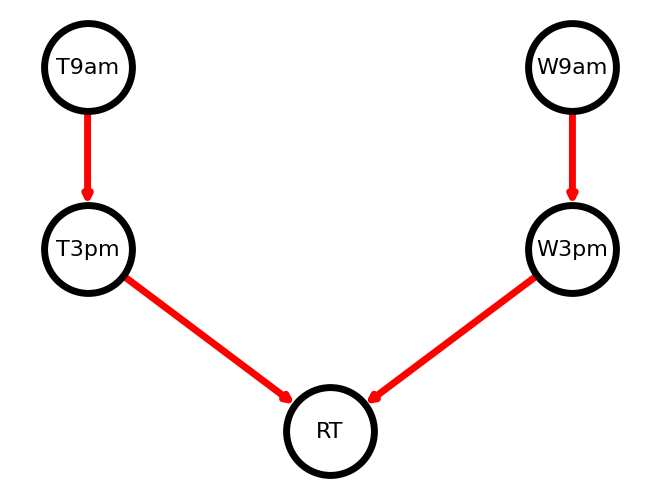

In [15]:

# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 2), 3: (1,0.5),4:(0,-1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show();

***Q5***

In [16]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:",node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.31934
3=>=15|0.68066
----------------
Node: 2|W9am|<16,>=16
Values:
2=<16|0.37773
2=>=16|0.62227
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.65118
1=24-36|0.32452
1=>36|0.02430
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.39486
0=15-26|0.51116
0=>26|0.09398
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.77522
4=Yes|0.22478
----------------


In [17]:
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

* Evidence 1: Time: 9 am, temperature: 30

In [18]:
evidence('ev1','T9am','>26',1.0)
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.31934
3=>=15|0.68066
----------------
Node: 2|W9am|<16,>=16
Values:
2=<16|0.37773
2=>=16|0.62227
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.05304
1=24-36|0.73936
1=>36|0.20761
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.00000
0=15-26|0.00000
0=>26|1.00000
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.85699
4=Yes|0.14301
----------------


* Evidence 2: Time: 9 am, temperature: 10

In [19]:
evidence('ev2','T9am','<15',1.0)
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.31934
3=>=15|0.68066
----------------
Node: 2|W9am|<16,>=16
Values:
2=<16|0.37773
2=>=16|0.62227
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.97533
1=24-36|0.02465
1=>36|0.00002
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|1.00000
0=15-26|0.00000
0=>26|0.00000
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.73655
4=Yes|0.26345
----------------


* Evidence 3: Time: 3 pm, temperature: 26

In [20]:
evidence('ev3','T3pm','24-36',1.0)
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.31934
3=>=15|0.68066
----------------
Node: 2|W9am|<16,>=16
Values:
2=<16|0.37773
2=>=16|0.62227
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.00000
1=24-36|1.00000
1=>36|0.00000
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|1.00000
0=15-26|0.00000
0=>26|0.00000
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.84740
4=Yes|0.15260
----------------


* Evidence 4: Time: 3 pm, temperature: 11


In [21]:
evidence('ev4','T3pm','<24',1.0)
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.31934
3=>=15|0.68066
----------------
Node: 2|W9am|<16,>=16
Values:
2=<16|0.37773
2=>=16|0.62227
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|1.00000
1=24-36|0.00000
1=>36|0.00000
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|1.00000
0=15-26|0.00000
0=>26|0.00000
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.73374
4=Yes|0.26626
----------------


* Evidence 5: Time: 9 am, Wind speed: 11

In [22]:
evidence('ev1','W9am','<16',1.0)
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.14557
3=>=15|0.85443
----------------
Node: 2|W9am|<16,>=16
Values:
2=<16|1.00000
2=>=16|0.00000
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|1.00000
1=24-36|0.00000
1=>36|0.00000
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|1.00000
0=15-26|0.00000
0=>26|0.00000
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.72377
4=Yes|0.27623
----------------


* Evidence 6: Time: 3 pm, Wind speed: 19

In [23]:
evidence('ev6','W3pm','>=15',1.0)
print_probs()

Node: 3|W3pm|<15,>=15
Values:
3=<15|0.00000
3=>=15|1.00000
----------------
Node: 2|W9am|<16,>=16
Values:
2=<16|1.00000
2=>=16|0.00000
----------------
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|1.00000
1=24-36|0.00000
1=>36|0.00000
----------------
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|1.00000
0=15-26|0.00000
0=>26|0.00000
----------------
Node: 4|RT|No,Yes
Values:
4=No|0.71542
4=Yes|0.28458
----------------
